## **Problem Statement**
# Use decision trees to prepare a model on fraud data 
## treating those who have taxable_income <= 30000 as "Risky" and others are "Good"

In [32]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE,  ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from dataprep.eda import plot, plot_correlation, plot_missing, create_report
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import  DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report,confusion_matrix,accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import Dataset
df = pd.read_csv('C:/Users/ketan mashere/Documents/Data Science Material/Data Science Assignments/Decision Tree/Fraud_check.csv')
df

Undergrad Marital.Status  Taxable.Income  City.Population  \
0          NO         Single           68833            50047   
1         YES       Divorced           33700           134075   
2          NO        Married           36925           160205   
3         YES         Single           50190           193264   
4          NO        Married           81002            27533   
..        ...            ...             ...              ...   
595       YES       Divorced           76340            39492   
596       YES       Divorced           69967            55369   
597        NO       Divorced           47334           154058   
598       YES        Married           98592           180083   
599        NO       Divorced           96519           158137   

     Work.Experience Urban  
0                 10   YES  
1                 18   YES  
2                 30   YES  
3                 15   YES  
4                 28    NO  
..               ...   ...  
595                7   YES  
596                2   YES  
597                0   YES  
598               17    NO  
599               16    NO  

[600 rows x 6 columns]

## 2. About Dataset<a class="anchor" id="2"></a>
Context\
Data Description :

+ Undergrad : person is under graduated or not
+ Marital.Status : marital status of a person
+ Taxable.Income : Taxable income is the amount of how much tax an individual owes to the government 
+ Work Experience : Work experience of an individual person
+ Urban : Whether that person belongs to urban area or not

## 3. Data Exploration <a class="anchor" id="3"></a>

Before doing anything else with the data let's see if there are any null values (missing data) in any of the columns.

In [6]:
df.isnull().any()

Undergrad          False
Marital.Status     False
Taxable.Income     False
City.Population    False
Work.Experience    False
Urban              False
dtype: bool

In [7]:
df.isnull().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

- We have no missing data so all the entries are valid for use.

- Now we can check the column names to get a better understanding of what features we will be basing our classification on.

### 3.1 Descriptive Analysis<a class="anchor" id="3.1"></a>

In [8]:
df.shape

(600, 6)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


In [10]:
df[df.duplicated()].shape

(0, 6)

In [12]:
df[df.duplicated()]

Empty DataFrame
Columns: [Undergrad, Marital.Status, Taxable.Income, City.Population, Work.Experience, Urban]
Index: []

In [13]:
df.describe()

Taxable.Income  City.Population  Work.Experience
count      600.000000       600.000000       600.000000
mean     55208.375000    108747.368333        15.558333
std      26204.827597     49850.075134         8.842147
min      10003.000000     25779.000000         0.000000
25%      32871.500000     66966.750000         8.000000
50%      55074.500000    106493.500000        15.000000
75%      78611.750000    150114.250000        24.000000
max      99619.000000    199778.000000        30.000000

The features are not on the same scale. For example `City.Population` has a mean of `108747.36` while `Work.Experience` has a mean value of `15.55`. Features should be on the same scale for algorithms such as logistic regression (gradient descent) to converge smoothly. Let's go ahead and check further.

### 3.2 Feature Engineering<a class="anchor" id="3.2"></a>

### Lets assume: taxable_income <= 30000 as “Risky=0” and others are “Good=1”

In [5]:
# Converting taxable_income <= 30000 as "Risky" and others are "Good"
df1=df.copy()
df1['taxable_category'] = pd.cut(x = df1['Taxable.Income'], bins = [10002,30000,99620], labels = ['Risky', 'Good'])
df1.head()

Undergrad Marital.Status  Taxable.Income  City.Population  Work.Experience  \
0        NO         Single           68833            50047               10   
1       YES       Divorced           33700           134075               18   
2        NO        Married           36925           160205               30   
3       YES         Single           50190           193264               15   
4        NO        Married           81002            27533               28   

  Urban taxable_category  
0   YES             Good  
1   YES             Good  
2   YES             Good  
3   YES             Good  
4    NO             Good

In [6]:
categorical_features = df.describe(include=["object"]).columns
categorical_features

Index(['Undergrad', 'Marital.Status', 'Urban'], dtype='object')

In [7]:
numerical_features = df.describe(include=["int64"]).columns
numerical_features

Index(['Taxable.Income', 'City.Population', 'Work.Experience'], dtype='object')

## 4. Data Visualization<a class="anchor" id="4"></a>

+ ###  Univariate plots<a class="anchor" id="4.1"></a>

Next let's get the distribution of animal data across the types of classes.

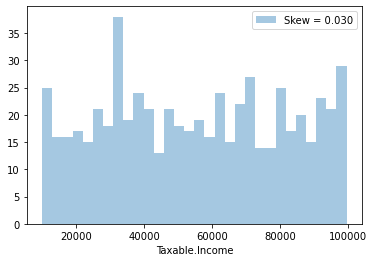

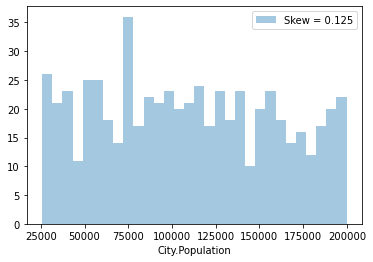

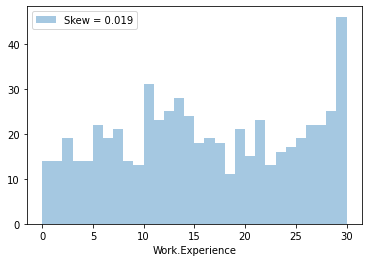

In [16]:
numerical_features=[feature for feature in df.columns if df[feature].dtypes != 'O']
for feat in numerical_features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

None of the features is normally distributed. The features Fe, Ba, Ca and K exhibit the highest skew coefficients. Moreover, the distribution of potassium (K) and Barium (Ba) seem to contain many outliers. Let's identify the indices of the observations containing outliers using Turkey's method.

In [17]:
# Detect observations with more than one outlier

def outlier_hunt(df):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in df.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(df[numerical_features])))) 

The dataset contains 0 observations with more than 2 outliers


##### there exists no observations with multiple outliers. 

Let's examine the boxplots for the several distributions

In [18]:
numerical_features

['Taxable.Income', 'City.Population', 'Work.Experience']

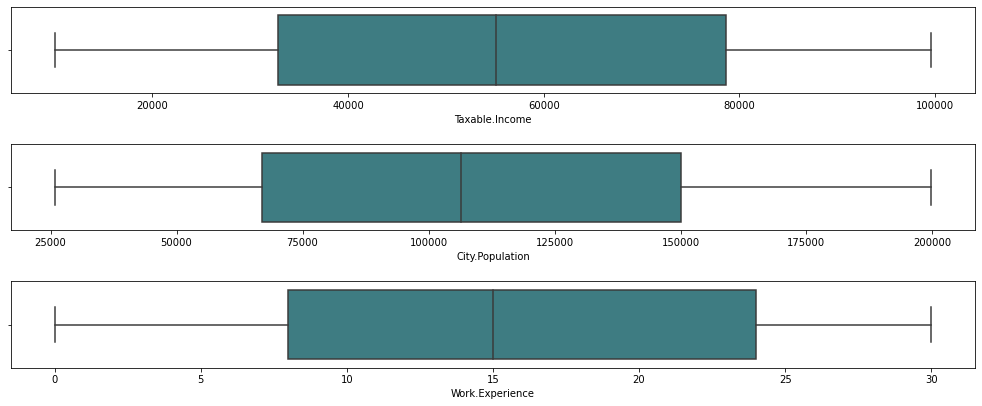

In [23]:
ot=df.copy() 
fig, axes=plt.subplots(3,1,figsize=(14,6),sharex=False,sharey=False)
sns.boxplot(x='Taxable.Income',data=ot,palette='crest',ax=axes[0])
sns.boxplot(x='City.Population',data=ot,palette='crest',ax=axes[1])
sns.boxplot(x='Work.Experience',data=ot,palette='crest',ax=axes[2])
plt.tight_layout(pad=2.0)

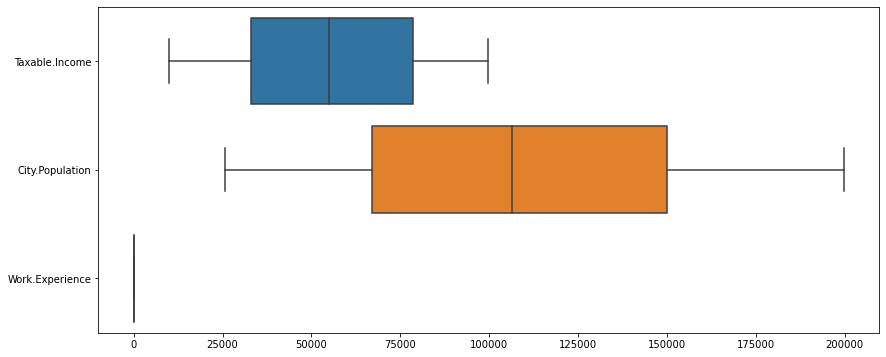

In [25]:
#outlier
plt.figure(figsize=(14,6))
sns.boxplot(data=df[numerical_features], orient="h");

#### Unsurprisingly, **`Work.Experience`** has a mean that is much inferior to the other constituents as we already saw in the previous section.

+ ### Multivariate Analysis<a class="anchor" id="4.2"></a>


Let's now proceed by drawing a pairplot to visually examine the correlation between the features.

<Figure size 576x576 with 0 Axes>

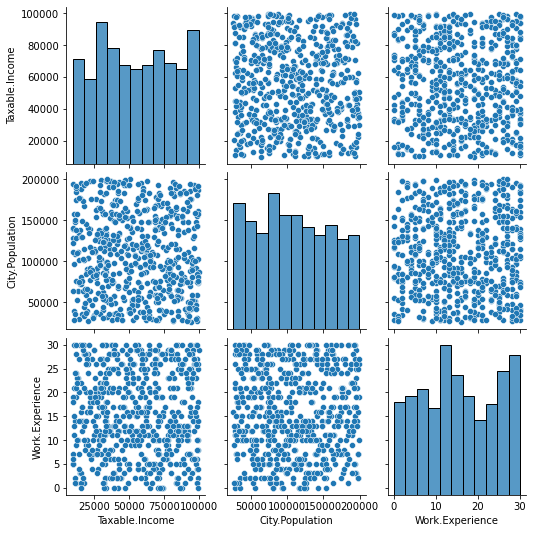

In [29]:
plt.figure(figsize=(8,8))
sns.pairplot(df, palette='coolwarm')
plt.show()

***Pearson's Correlation Coefficient***: helps you find out the relationship between two quantities. It gives you the measure of the strength of association between two variables. The value of Pearson's Correlation Coefficient can be between -1 to +1. 1 means that they are highly correlated and 0 means no correlation.

A heat map is a two-dimensional representation of information with the help of colors. Heat maps can help the user visualize simple or complex information.

<AxesSubplot:>

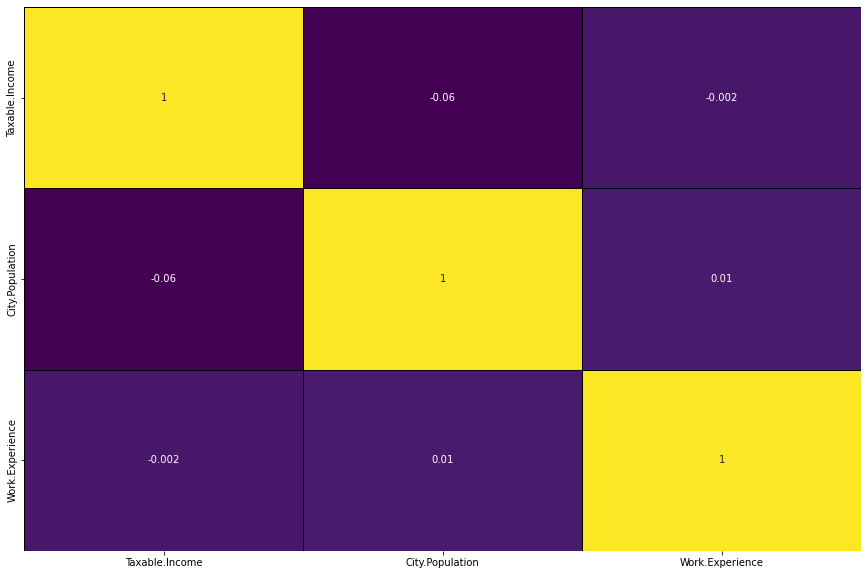

In [30]:
# Having a look at the correlation matrix

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, fmt='.1g', cmap="viridis", cbar=False, linewidths=0.5, linecolor='black')

Index(['Undergrad', 'Marital.Status', 'Urban'], dtype='object')


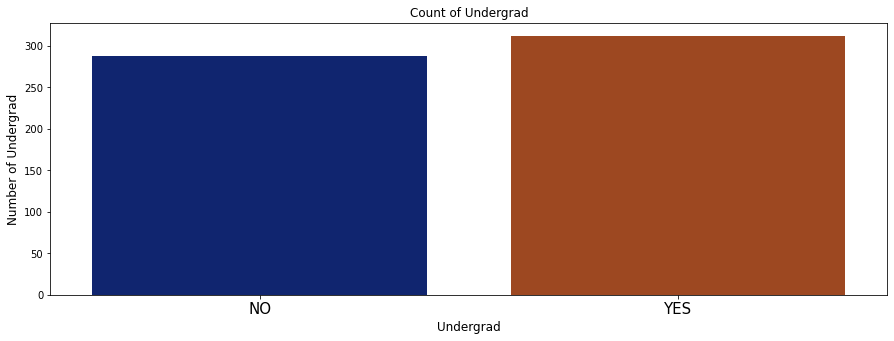

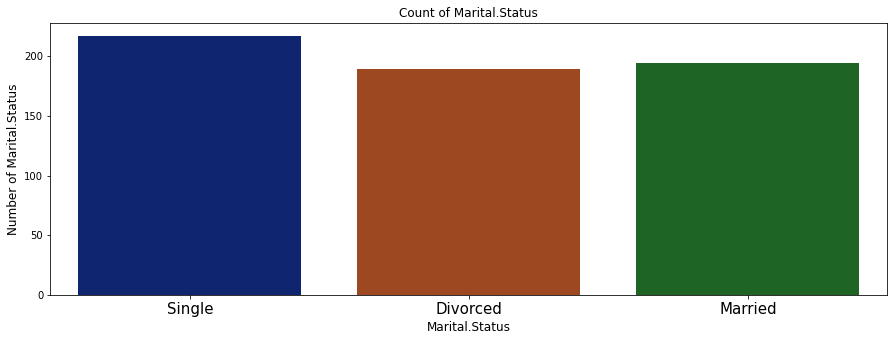

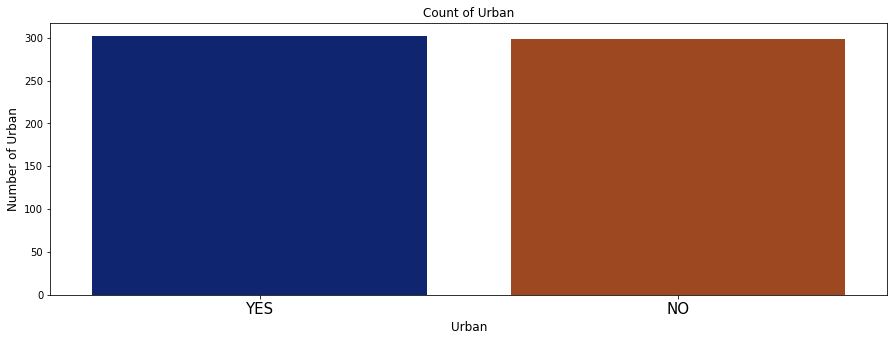

In [36]:
print(categorical_features)

for idx, column in enumerate(categorical_features):
    plt.figure(figsize=(15, 5))
    unique = df[column].value_counts(ascending=True);
 
    #plt.subplot(1, len(categorical_features), idx+1)    
    plt.title("Count of "+ column)
    sns.countplot(data=df, x=column,palette = "dark")
    #plt.bar(unique.index, unique.values);
    plt.xticks(rotation = 0, size = 15)
    
    plt.xlabel(column, fontsize=12)
    plt.ylabel("Number of "+ column, fontsize=12)

In [39]:
def factorplot(param):
    sns.factorplot(x =param, size = 7, aspect = 2, data = df, y= "Taxable.Income", palette = "dark")
    plt.xlabel("\n" + param)
    plt.ylabel("Sales\n")
    plt.show()

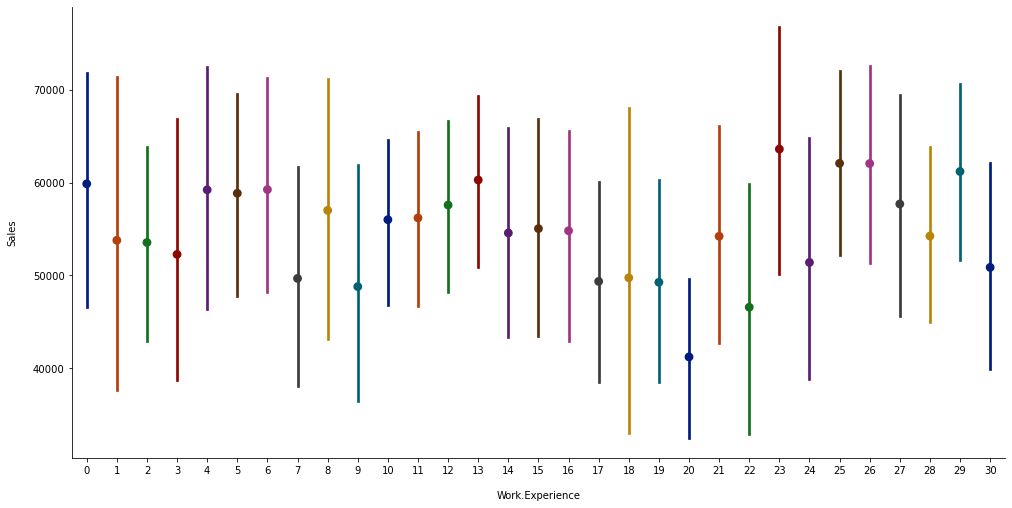

In [40]:
factorplot("Work.Experience")

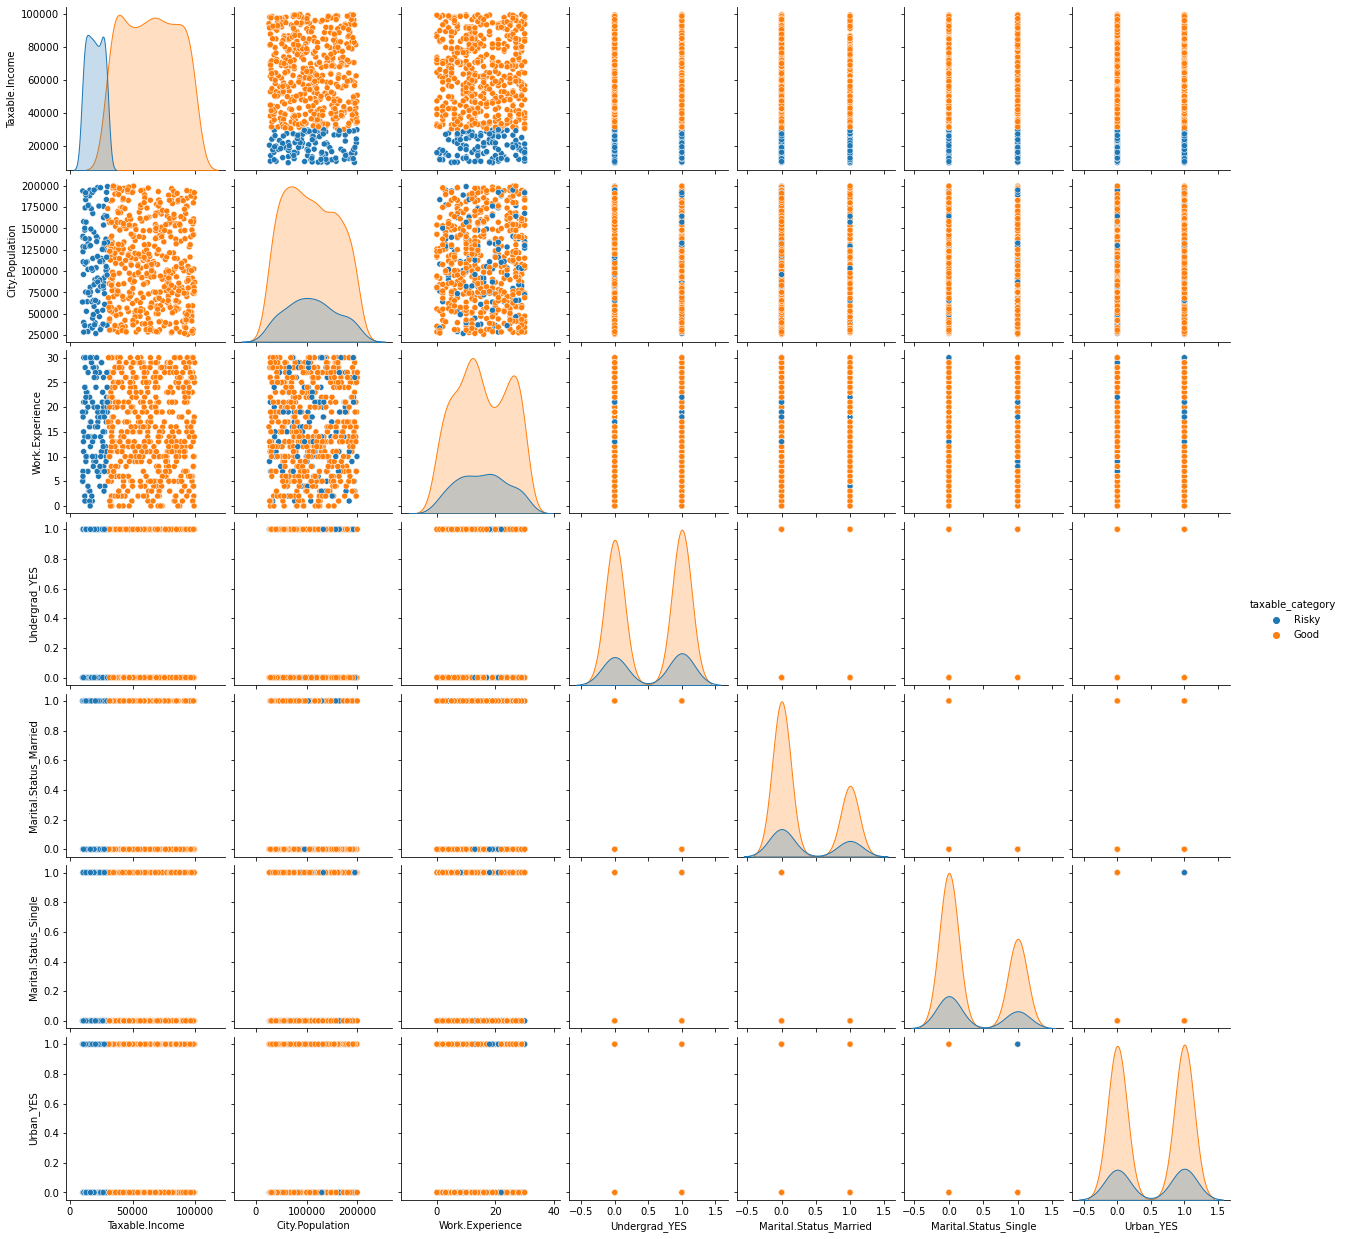

In [50]:
# let's plot pair plot to visualise the attributes all at once
import seaborn as sns
sns.pairplot(data=df1, hue = 'taxable_category')

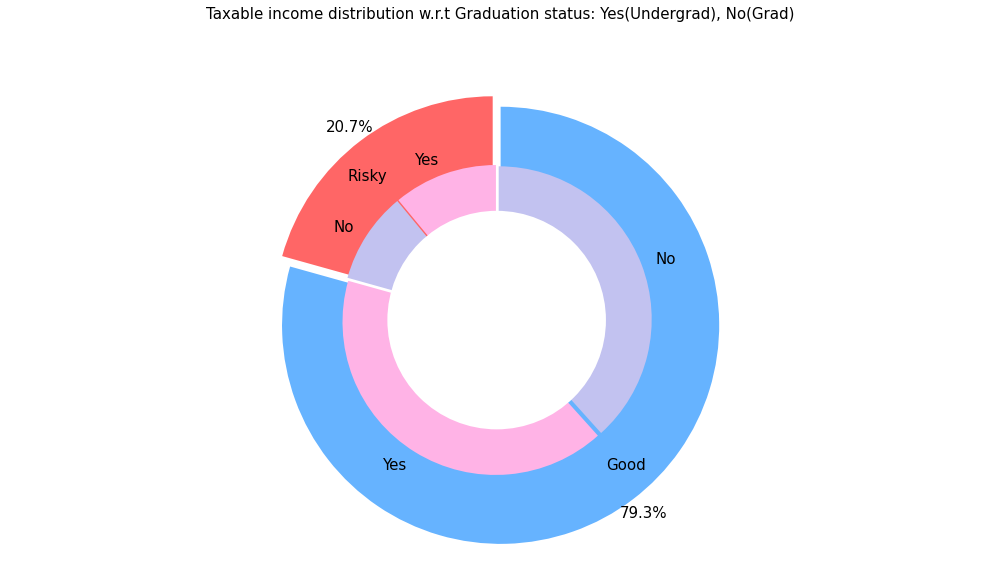

In [77]:
plt.figure(figsize=(14, 8))
labels =["Risky", "Good"]
values = [df1["taxable_category"][df1["taxable_category"] == 'Risky'].groupby(by = df1.Undergrad).count().sum(),
         df1["taxable_category"][df1["taxable_category"] == 'Good'].groupby(by = df1.Undergrad).count().sum()]
labels_gender = ["Yes","No","Yes","No"]
sizes_gender = [66,58 , 246,230]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#ffb3e6', '#c2c2f0']
explode = (0.3,0.3) 
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution w.r.t Graduation status: Yes(Undergrad), No(Grad)', fontsize=15, y=1.1)

# show plot 
 
plt.axis('equal')
plt.tight_layout()
plt.show()

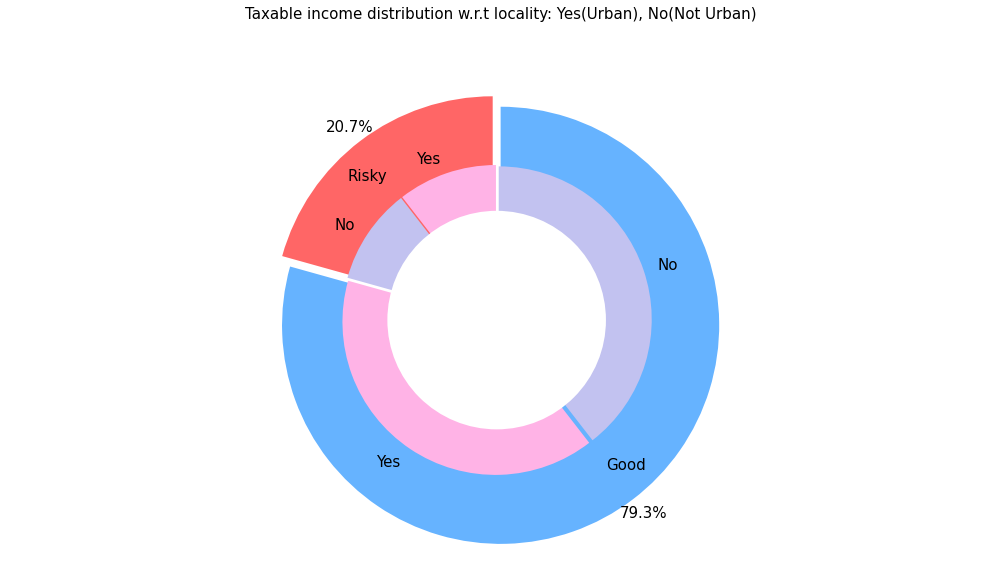

In [79]:
plt.figure(figsize=(14, 8))
labels =["Risky", "Good"]
values = [df1["taxable_category"][df1["taxable_category"] == 'Risky'].groupby(by = df1.Urban).count().sum(),
         df1["taxable_category"][df1["taxable_category"] == 'Good'].groupby(by = df1.Urban).count().sum()]
labels_gender = ["Yes","No","Yes","No"]
sizes_gender = [63,61 , 239,237]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#ffb3e6', '#c2c2f0']
explode = (0.3,0.3) 
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution w.r.t locality: Yes(Urban), No(Not Urban)', fontsize=15, y=1.1)

# show plot 
 
plt.axis('equal')
plt.tight_layout()
plt.show()

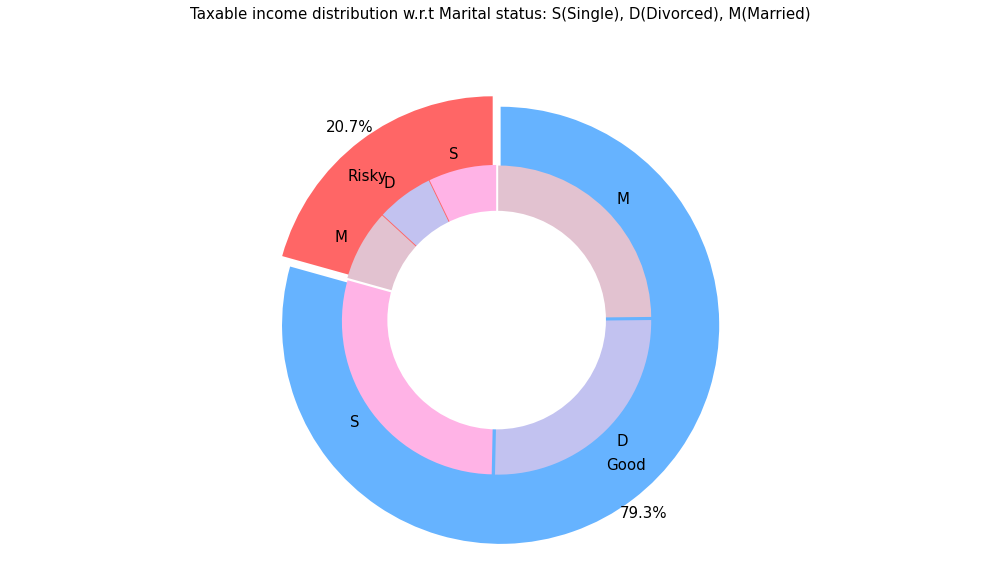

In [80]:
plt.figure(figsize=(14, 8))
labels =["Risky", "Good"]
values = [df1["taxable_category"][df1["taxable_category"] == 'Risky'].groupby(by = df1["Marital.Status"]).count().sum(),
         df1["taxable_category"][df1["taxable_category"] == 'Good'].groupby(by = df1["Marital.Status"]).count().sum()]
labels_gender = ["","D","M","S","D", "M"]
sizes_gender = [43,36,45,174,153,149]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#e2c2d0','#ffb3e6', '#c2c2f0', '#e2c2d0']
explode = (0.3,0.3) 
explode_gender = (0.1,0.1,0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution w.r.t Marital status: S(Single), D(Divorced), M(Married)', fontsize=15, y=1.1)

# show plot 
 
plt.axis('equal')
plt.tight_layout()
plt.show()

#### Checking for Imbalanced or balanced dataset with regards to the Target

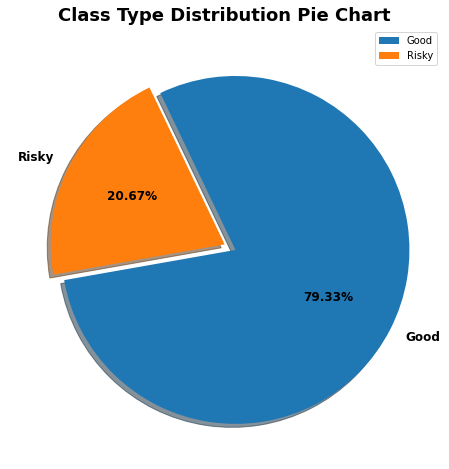

In [69]:
plt.figure(figsize = (12,8))
plt.pie(df1['taxable_category'].value_counts(),
       labels=df1.taxable_category.unique(),
       explode = [0.07,0.0],
       autopct= '%.2f%%',
       shadow= True,
       startangle= 190,
       textprops = {'size':'large',
                   'fontweight':'bold',
                    'rotation':'0',
                   'color':'black'})
plt.legend(loc= 'upper right')
plt.title("Class Type Distribution Pie Chart", fontsize = 18, fontweight = 'bold')
plt.show()

##### Imbalanced data refers to those types of datasets where the target class has an uneven distribution of observations, i.e one class label has a very high number of observations and the other has a very low number of observations.

Here, the class “Good” is called the majority class, and the much smaller in size “Risky” class is called the minority class.

In [11]:
countNotermdeposit = len(df1[df1['taxable_category'] == 'Good'])
counthavetermdeposit = len(df1[df1['taxable_category'] == 'Risky'])
print("Percentage of Customer doesn't have a term deposit: {:.2f}%".format((countNotermdeposit / (len(df.taxable_category))*100)))
print("Percentage of Customer have a term deposit: {:.2f}%".format((counthavetermdeposit / (len(df.taxable_category))*100)))

Percentage of Customer doesn't have a term deposit: 79.33%
Percentage of Customer have a term deposit: 20.67%


In [82]:
df1.taxable_category.value_counts()

Good     476
Risky    124
Name: taxable_category, dtype: int64

Text(0.5, 1.0, 'Risky or Good for Individual Taxable Income ')

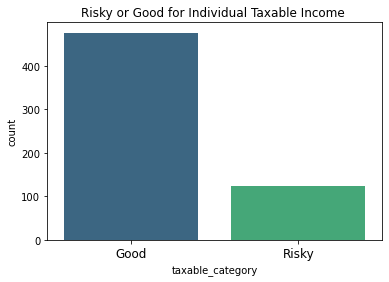

In [84]:
sns.countplot(x='taxable_category', data=df1, palette = 'viridis', 
              order=df1['taxable_category'].value_counts().index)
plt.xticks(fontsize = 12)
plt.title('Risky or Good for Individual Taxable Income ')

## 5. Data Pre-Processing<a class="anchor" id="5"></a>

In [8]:
data = df1.copy()
data.rename(columns={'Marital.Status':'Marital_Status', 'Taxable.Income':'Taxable_Income','Work.Experience':'Work_Experience','City.Population':'City_Population'}, inplace = True)
data.drop('Taxable_Income', axis=1, inplace = True)
categorical_features = data.describe(include=["object",'category']).columns
categorical_features

Index(['Undergrad', 'Marital_Status', 'Urban', 'taxable_category'], dtype='object')

In [9]:
#Creating dummy vairables of the categorical features
le = LabelEncoder()
for col in categorical_features:
        le.fit(data[col])
        data[col] = le.transform(data[col])
data.head()

Undergrad  Marital_Status  City_Population  Work_Experience  Urban  \
0          0               2            50047               10      1   
1          1               0           134075               18      1   
2          0               1           160205               30      1   
3          1               2           193264               15      1   
4          0               1            27533               28      0   

   taxable_category  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

In [14]:
data.taxable_category.value_counts()

0    476
1    124
Name: taxable_category, dtype: int64

In [10]:
x = data.drop('taxable_category',axis=1)
y = data['taxable_category']

In [11]:
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# enumerate the splits and summarize the distributions
for train_ix, test_ix in skf.split(x, y):
# select rows
    train_X, test_X = x.iloc[train_ix], x.loc[test_ix]
    train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]
# summarize train and test composition
    train, train1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test, test1 = len(test_y[test_y==0]), len(test_y[test_y==1])
    print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train, train1, test, test1))

>Train: 0=428, 1=112, Test: 0=48, 1=12
>Train: 0=428, 1=112, Test: 0=48, 1=12
>Train: 0=428, 1=112, Test: 0=48, 1=12
>Train: 0=428, 1=112, Test: 0=48, 1=12
>Train: 0=428, 1=112, Test: 0=48, 1=12
>Train: 0=428, 1=112, Test: 0=48, 1=12
>Train: 0=429, 1=111, Test: 0=47, 1=13
>Train: 0=429, 1=111, Test: 0=47, 1=13
>Train: 0=429, 1=111, Test: 0=47, 1=13
>Train: 0=429, 1=111, Test: 0=47, 1=13


In [12]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0,stratify=y)

In [13]:
# summarize
train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

>Train: 0=333, 1=87, Test: 0=143, 1=37


In [14]:
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (420, 5)
Shape of X_test:  (180, 5)
Shape of y_train:  (420,)
Shape of y_test (180,)


### 6.1. Grid search using Stratified Kfold Splits on Imbalanced Dataset<a class="anchor" id="6.1"></a> 

In [49]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [51]:
params = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 20))), 
    "min_samples_split":[2, 3, 4], 
    "min_samples_leaf":list(range(1, 20)), 
}


tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
tree_cv.fit(train_X, train_y)
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(train_X, train_y)
print_score(tree_clf, train_X, train_y, test_X, test_y, train=True)
print_score(tree_clf, train_X, train_y, test_X, test_y, train=False)

Fitting 3 folds for each of 4332 candidates, totalling 12996 fits
Best paramters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'})
Train Result:
Accuracy Score: 79.44%
_______________________________________________
CLASSIFICATION REPORT:
                    0      1  accuracy   macro avg  weighted avg
precision    0.794444    0.0  0.794444    0.397222      0.631142
recall       1.000000    0.0  0.794444    0.500000      0.794444
f1-score     0.885449    0.0  0.794444    0.442724      0.703440
support    429.000000  111.0  0.794444  540.000000    540.000000
_______________________________________________
Confusion Matrix: 
 [[429   0]
 [111   0]]

Test Result:
Accuracy Score: 78.33%
_______________________________________________
CLASSIFICATION REPORT:
                   0     1  accuracy  macro avg  weighted avg
precision   0.783333   0.0  0.783333   0.391667      0.613611
recall      1.000000   0.0  0.783333   0.500000      0.7

In [38]:
# Get score for different values of n
decision_tree = DecisionTreeClassifier()
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

results = cross_val_score(decision_tree, train_X, train_y, cv=skf)
print(results.mean())

0.6203703703703702


In [39]:
param_dict = {
    "criterion":["gini","entropy"],
    "max_depth":range(1,10),
    "min_samples_split":range(1,10),
    "min_samples_leaf":range(1,10)
}

grid = GridSearchCV(decision_tree,
                   param_grid = param_dict,
                   cv=skf,
                   verbose=1,
                   n_jobs=6)

grid.fit(train_X,train_y)

model = grid.best_estimator_

Fitting 10 folds for each of 1458 candidates, totalling 14580 fits


In [40]:
grid.best_score_

0.7944444444444444

In [41]:
predict_output = model.predict(test_X)
accuracy_test = accuracy_score(test_y,predict_output)
accuracy_test

0.7833333333333333

              precision    recall  f1-score   support

           0       0.78      1.00      0.88        47
           1       0.00      0.00      0.00        13

    accuracy                           0.78        60
   macro avg       0.39      0.50      0.44        60
weighted avg       0.61      0.78      0.69        60



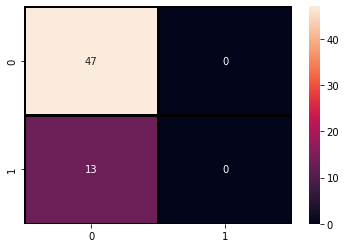

In [42]:
sns.heatmap(confusion_matrix(test_y, predict_output),annot=True,fmt = "d",linecolor="k",linewidths=3)
print(classification_report(test_y,predict_output))

### 6.2 Grid search using Train Test Splits Stratifying Target feature on Imbalanced Dataset<a class="anchor" id="6.2"></a> 

In [52]:
params = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 20))), 
    "min_samples_split":[2, 3, 4], 
    "min_samples_leaf":list(range(1, 20)), 
}


tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
tree_cv.fit(x_train, y_train)
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(x_train, y_train)
print_score(tree_clf, x_train, y_train, x_test, y_test, train=True)
print_score(tree_clf, x_train, y_train, x_test, y_test, train=False)

Fitting 3 folds for each of 4332 candidates, totalling 12996 fits
Best paramters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'})
Train Result:
Accuracy Score: 79.29%
_______________________________________________
CLASSIFICATION REPORT:
                    0     1  accuracy   macro avg  weighted avg
precision    0.792857   0.0  0.792857    0.396429      0.628622
recall       1.000000   0.0  0.792857    0.500000      0.792857
f1-score     0.884462   0.0  0.792857    0.442231      0.701252
support    333.000000  87.0  0.792857  420.000000    420.000000
_______________________________________________
Confusion Matrix: 
 [[333   0]
 [ 87   0]]

Test Result:
Accuracy Score: 79.44%
_______________________________________________
CLASSIFICATION REPORT:
                    0     1  accuracy   macro avg  weighted avg
precision    0.794444   0.0  0.794444    0.397222      0.631142
recall       1.000000   0.0  0.794444    0.500000      0.

In [53]:
# Get score for different values of n
decision_tree = DecisionTreeClassifier()
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

results = cross_val_score(decision_tree, x_train, y_train, cv=skf)
print(results.mean())

0.6428571428571429


In [54]:
param_dict = {
    "criterion":["gini","entropy"],
    "max_depth":range(1,10),
    "min_samples_split":range(1,10),
    "min_samples_leaf":range(1,10)
}

grid = GridSearchCV(decision_tree,
                   param_grid = param_dict,
                   cv=skf,
                   verbose=1,
                   n_jobs=6)

grid.fit(x_train,y_train)

model = grid.best_estimator_

Fitting 10 folds for each of 1458 candidates, totalling 14580 fits


In [55]:
grid.best_score_

0.7928571428571429

In [56]:
predict_output = model.predict(x_test)
accuracy_test = accuracy_score(y_test,predict_output)
accuracy_test

0.7944444444444444

              precision    recall  f1-score   support

           0       0.79      1.00      0.89       143
           1       0.00      0.00      0.00        37

    accuracy                           0.79       180
   macro avg       0.40      0.50      0.44       180
weighted avg       0.63      0.79      0.70       180



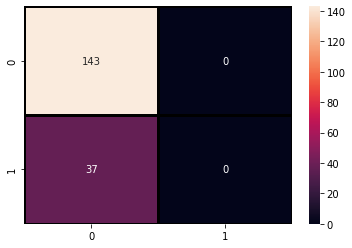

In [57]:
sns.heatmap(confusion_matrix(y_test, predict_output),annot=True,fmt = "d",linecolor="k",linewidths=3)
print(classification_report(y_test,predict_output))

#### Observation: 
+ In both the condition, due to imbalanced dataset our results are getting biased towards the majority. The model is correctly classifying all the majority classes yet fails to classify the minority classes. Hence, we need to use some kind of oversampling techniques to balance the dataset.

## 7. Handling imbalance data using SMOTE based techniques<a class="anchor" id="7"></a> 

In [15]:
x = data.drop(['taxable_category'], axis=1)
y = data['taxable_category']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.30, random_state=0,stratify=y)

In [16]:
# summarize
train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

>Train: 0=333, 1=87, Test: 0=143, 1=37
Shape of X_train:  (420, 5)
Shape of X_test:  (180, 5)
Shape of y_train:  (420,)
Shape of y_test (180,)


### 7.1 SMOTE Oversampling technique<a class="anchor" id="7.1"></a> 

In [22]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()
x_train_sm, y_train_sm = smt.fit_resample(x_train, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 333, 1: 333})


In [17]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using ADASYN
ada = ADASYN(random_state=130)
x_train_ada, y_train_ada = ada.fit_resample(x_train, y_train)

counter = Counter(y_train_ada)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 333, 1: 327})


In [18]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE + Tomek
smtom = SMOTETomek(random_state=139)
x_train_smtom, y_train_smtom = smtom.fit_resample(x_train, y_train)

counter = Counter(y_train_smtom)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 239, 1: 239})


### 7.4 Hybridization: SMOTE + ENN<a class="anchor" id="7.4"></a> 
SMOTE + ENN is another hybrid technique where more no. of observations are removed from the sample space. Here, ENN is yet another undersampling technique where the nearest neighbors of each of the majority class is estimated. If the nearest neighbors misclassify that particular instance of the majority class, then that instance gets deleted.

Integrating this technique with oversampled data done by SMOTE helps in doing extensive data cleaning. Here on misclassification by NN’s samples from both the classes are removed. This results in a more clear and concise class separation.

<b>Python Code for SMOTE + ENN algorithm:

In [19]:
counter = Counter(y_train)
print('Before',counter)
#oversampling the train dataset using SMOTE + ENN
smenn = SMOTEENN()
x_train_smenn, y_train_smenn = smenn.fit_resample(x_train, y_train)

counter = Counter(y_train_smenn)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 87, 1: 82})


##### The below-given picture shows how different SMOTE based resampling techniques work out to deal with imbalanced data.

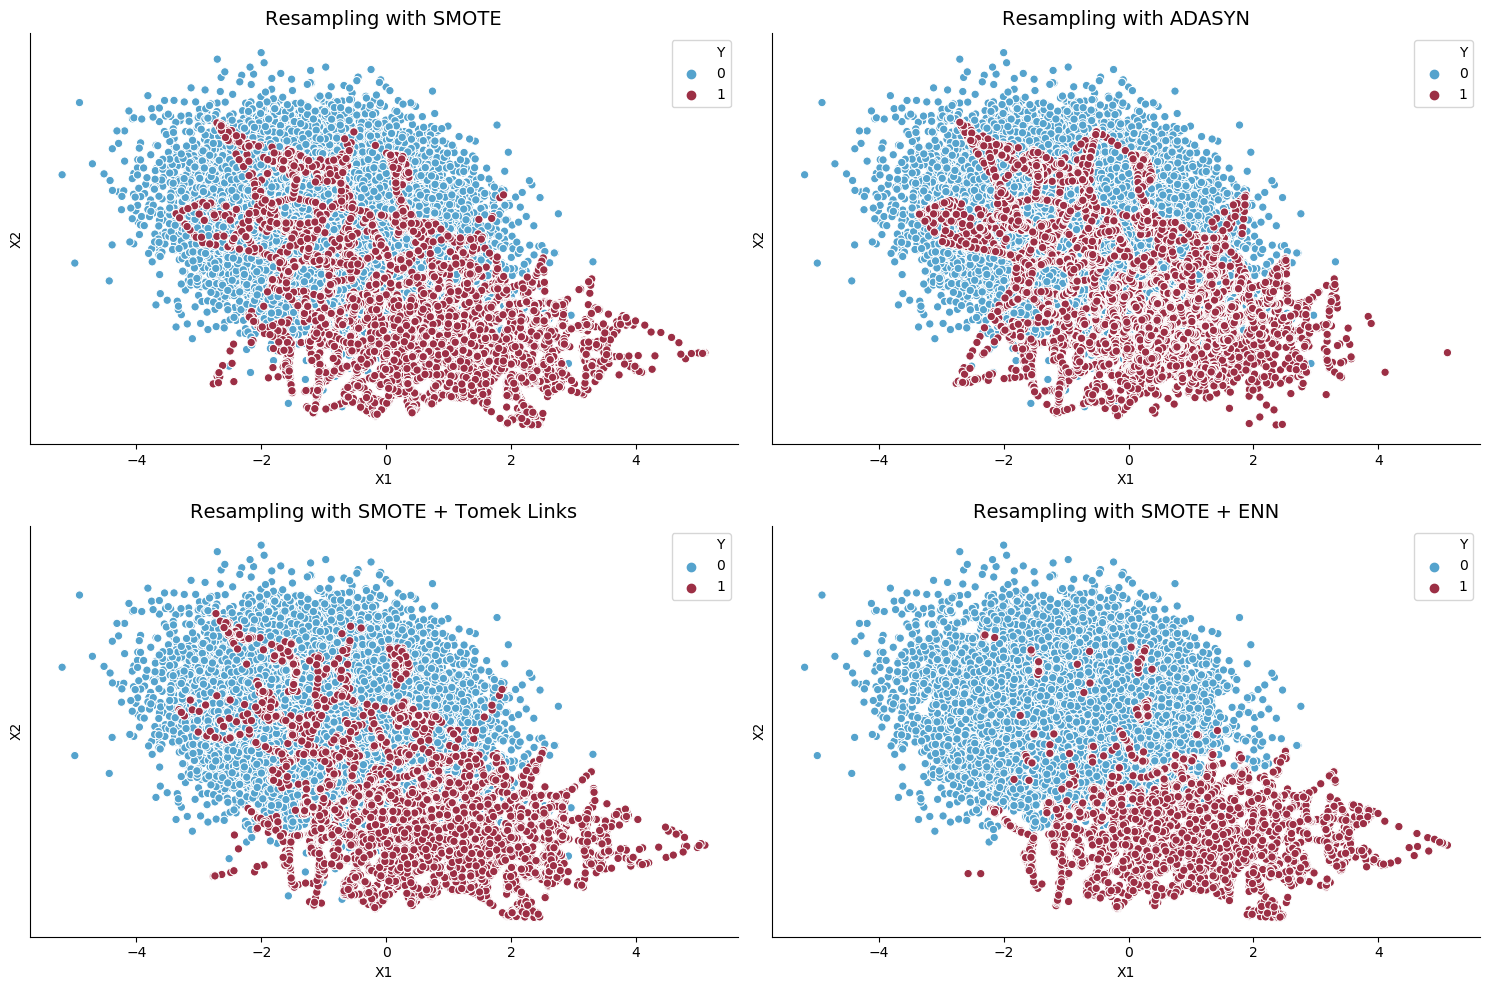

![Filter_Method](https://c.tenor.com/uIXA-brBP9UAAAAC/thanos-perfectlybalanced.gif)

### 7.5 SMOTE + UNDER SAMPLING<a class="anchor" id="7.5"></a> 

In [20]:
sm = SMOTE(sampling_strategy = .3)
rus =  RandomUnderSampler(sampling_strategy=.4)

pipeline = Pipeline(steps = [('smote', sm),('under',rus)])

counter = Counter(y_train)
print('Before',counter)
#over and undersampling the train dataset using SMOTE + RandomUnderSampler
x_train_smrus, y_train_smrus = pipeline.fit_resample(x_train, y_train)

counter = Counter(y_train_smrus)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 247, 1: 99})


[Table of Contents](#0.1)

### 7.6 Performance Analysis after Resampling<a class="anchor" id="7.6"></a> 

In [23]:
sampled_data = {
    'ACTUAL':[x_train, y_train],
    'SMOTE':[x_train_sm, y_train_sm],
    'ADASYN':[x_train_ada, y_train_ada],
    'SMOTE_TOMEK':[x_train_smtom, y_train_smtom],
    'SMOTE_ENN':[x_train_smenn, y_train_smenn],
    'UNDERSAMPLING': [x_train_smrus, y_train_smrus]
}

In [24]:
def test_eval(clf_model, X_test, y_test, algo=None, sampling=None):
    # Test set prediction
    y_prob=clf_model.predict_proba(X_test)
    y_pred=clf_model.predict(X_test)

    print('Confusion Matrix')
    print('='*60)
    #plot_confusion_matrix(clf_model, X_test, y_test)  
    #plt.show() 
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_test, y_prob[:,1]))
    
    #x = roc_auc_score(y_test, y_prob[:,1])
    f1 = f1_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    precision = precision_score(y_test, y_pred, average='binary')
          
    
    return algo,precision,recall,f1,sampling

In [25]:
model_params = {
    'decision_tree' :{
        'model' :  DecisionTreeClassifier(),
        'params' : {
             'max_depth': [i for i in range(5,16,2)],
             'min_samples_split': [2, 5, 10, 15, 20, 50, 100],
             'min_samples_leaf': [1, 2, 5],
             'criterion': ['gini', 'entropy'],
             'max_features': ['log2', 'sqrt', 'auto']
        }
        
    }
    
}

In [35]:
cv = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)
output = []
for model , model_hp in model_params.items():
    for resam , data in sampled_data.items():
        clf = RandomizedSearchCV(model_hp['model'], model_hp['params'],cv = cv, scoring='roc_auc', n_jobs=-1 )
        clf.fit(data[0], data[1])
        clf_best = clf.best_estimator_
        print('x'*60)
        print(model+' with ' + resam)
        print('='*60)
        output.append(test_eval(clf_best, x_test, y_test, model, resam))

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
decision_tree with ACTUAL
Confusion Matrix
[[142   1]
 [ 37   0]] 

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.99      0.88       143
           1       0.00      0.00      0.00        37

    accuracy                           0.79       180
   macro avg       0.40      0.50      0.44       180
weighted avg       0.63      0.79      0.70       180
 

AUC-ROC
0.44953694953694956
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
decision_tree with SMOTE
Confusion Matrix
[[78 65]
 [19 18]] 

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.55      0.65       143
           1       0.22      0.49      0.30        37

    accuracy                           0.53       180
   macro avg       0.51      0.52      0.47       180
weighted avg       0.68      0.53      0.58       180
 

AUC-ROC
0.4982989

#### As the results can be compared, SMOTE TOMEK Hybridization technique gave the best results we are going to use it further 

In [38]:
counter = Counter(y)
print('Before',counter)
# oversampling the train dataset using SMOTE + Tomek
smtom = SMOTETomek(random_state=0)
x_train_smtom, y_train_smtom = smtom.fit_resample(x, y)

counter = Counter(y_train_smtom)
print('After',counter)

Before Counter({0: 476, 1: 124})
After Counter({0: 354, 1: 354})


In [39]:
x_train,x_test,y_train,y_test = train_test_split(x_train_smtom,y_train_smtom,test_size=0.3,random_state=0, stratify=y_train_smtom)

counter = Counter(y_train_smtom)
print('Before',counter)
counter = Counter(y_train)
print('After',counter)
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Before Counter({0: 354, 1: 354})
After Counter({1: 248, 0: 247})
Shape of X_train:  (495, 5)
Shape of X_test:  (213, 5)
Shape of y_train:  (495,)
Shape of y_test (213,)


In [49]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

params = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 6))), 
    "min_samples_split":[2, 3, 4], 
    "min_samples_leaf":list(range(1, 6)), 
}


tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=10)
tree_cv.fit(x_train, y_train)
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(x_train, y_train)
print_score(tree_clf, x_train, y_train, x_test, y_test, train=True)
print_score(tree_clf, x_train, y_train, x_test, y_test, train=False)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits
Best paramters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'})
Train Result:
Accuracy Score: 72.53%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.796791    0.681818  0.725253    0.739305      0.739189
recall       0.603239    0.846774  0.725253    0.725007      0.725253
f1-score     0.686636    0.755396  0.725253    0.721016      0.721085
support    247.000000  248.000000  0.725253  495.000000    495.000000
_______________________________________________
Confusion Matrix: 
 [[149  98]
 [ 38 210]]

Test Result:
Accuracy Score: 63.38%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.745763    0.590909  0.633803    0.668336      0.668699
recall       

#### This is a balanced state of training and testing accuracy are close to each other where there is no overfitting or underfitting yet we can do better than this, let's try post pruning technique using <font color='red'><b>Alpha</b></font> Values

### 8.1 Building Decision Tree Classifier using Entropy Criteria with Alpha values Post Pruning<a class="anchor" id="8.1"></a> 

In [44]:
model_entropy = DecisionTreeClassifier(criterion='entropy', random_state=0)
model_entropy.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

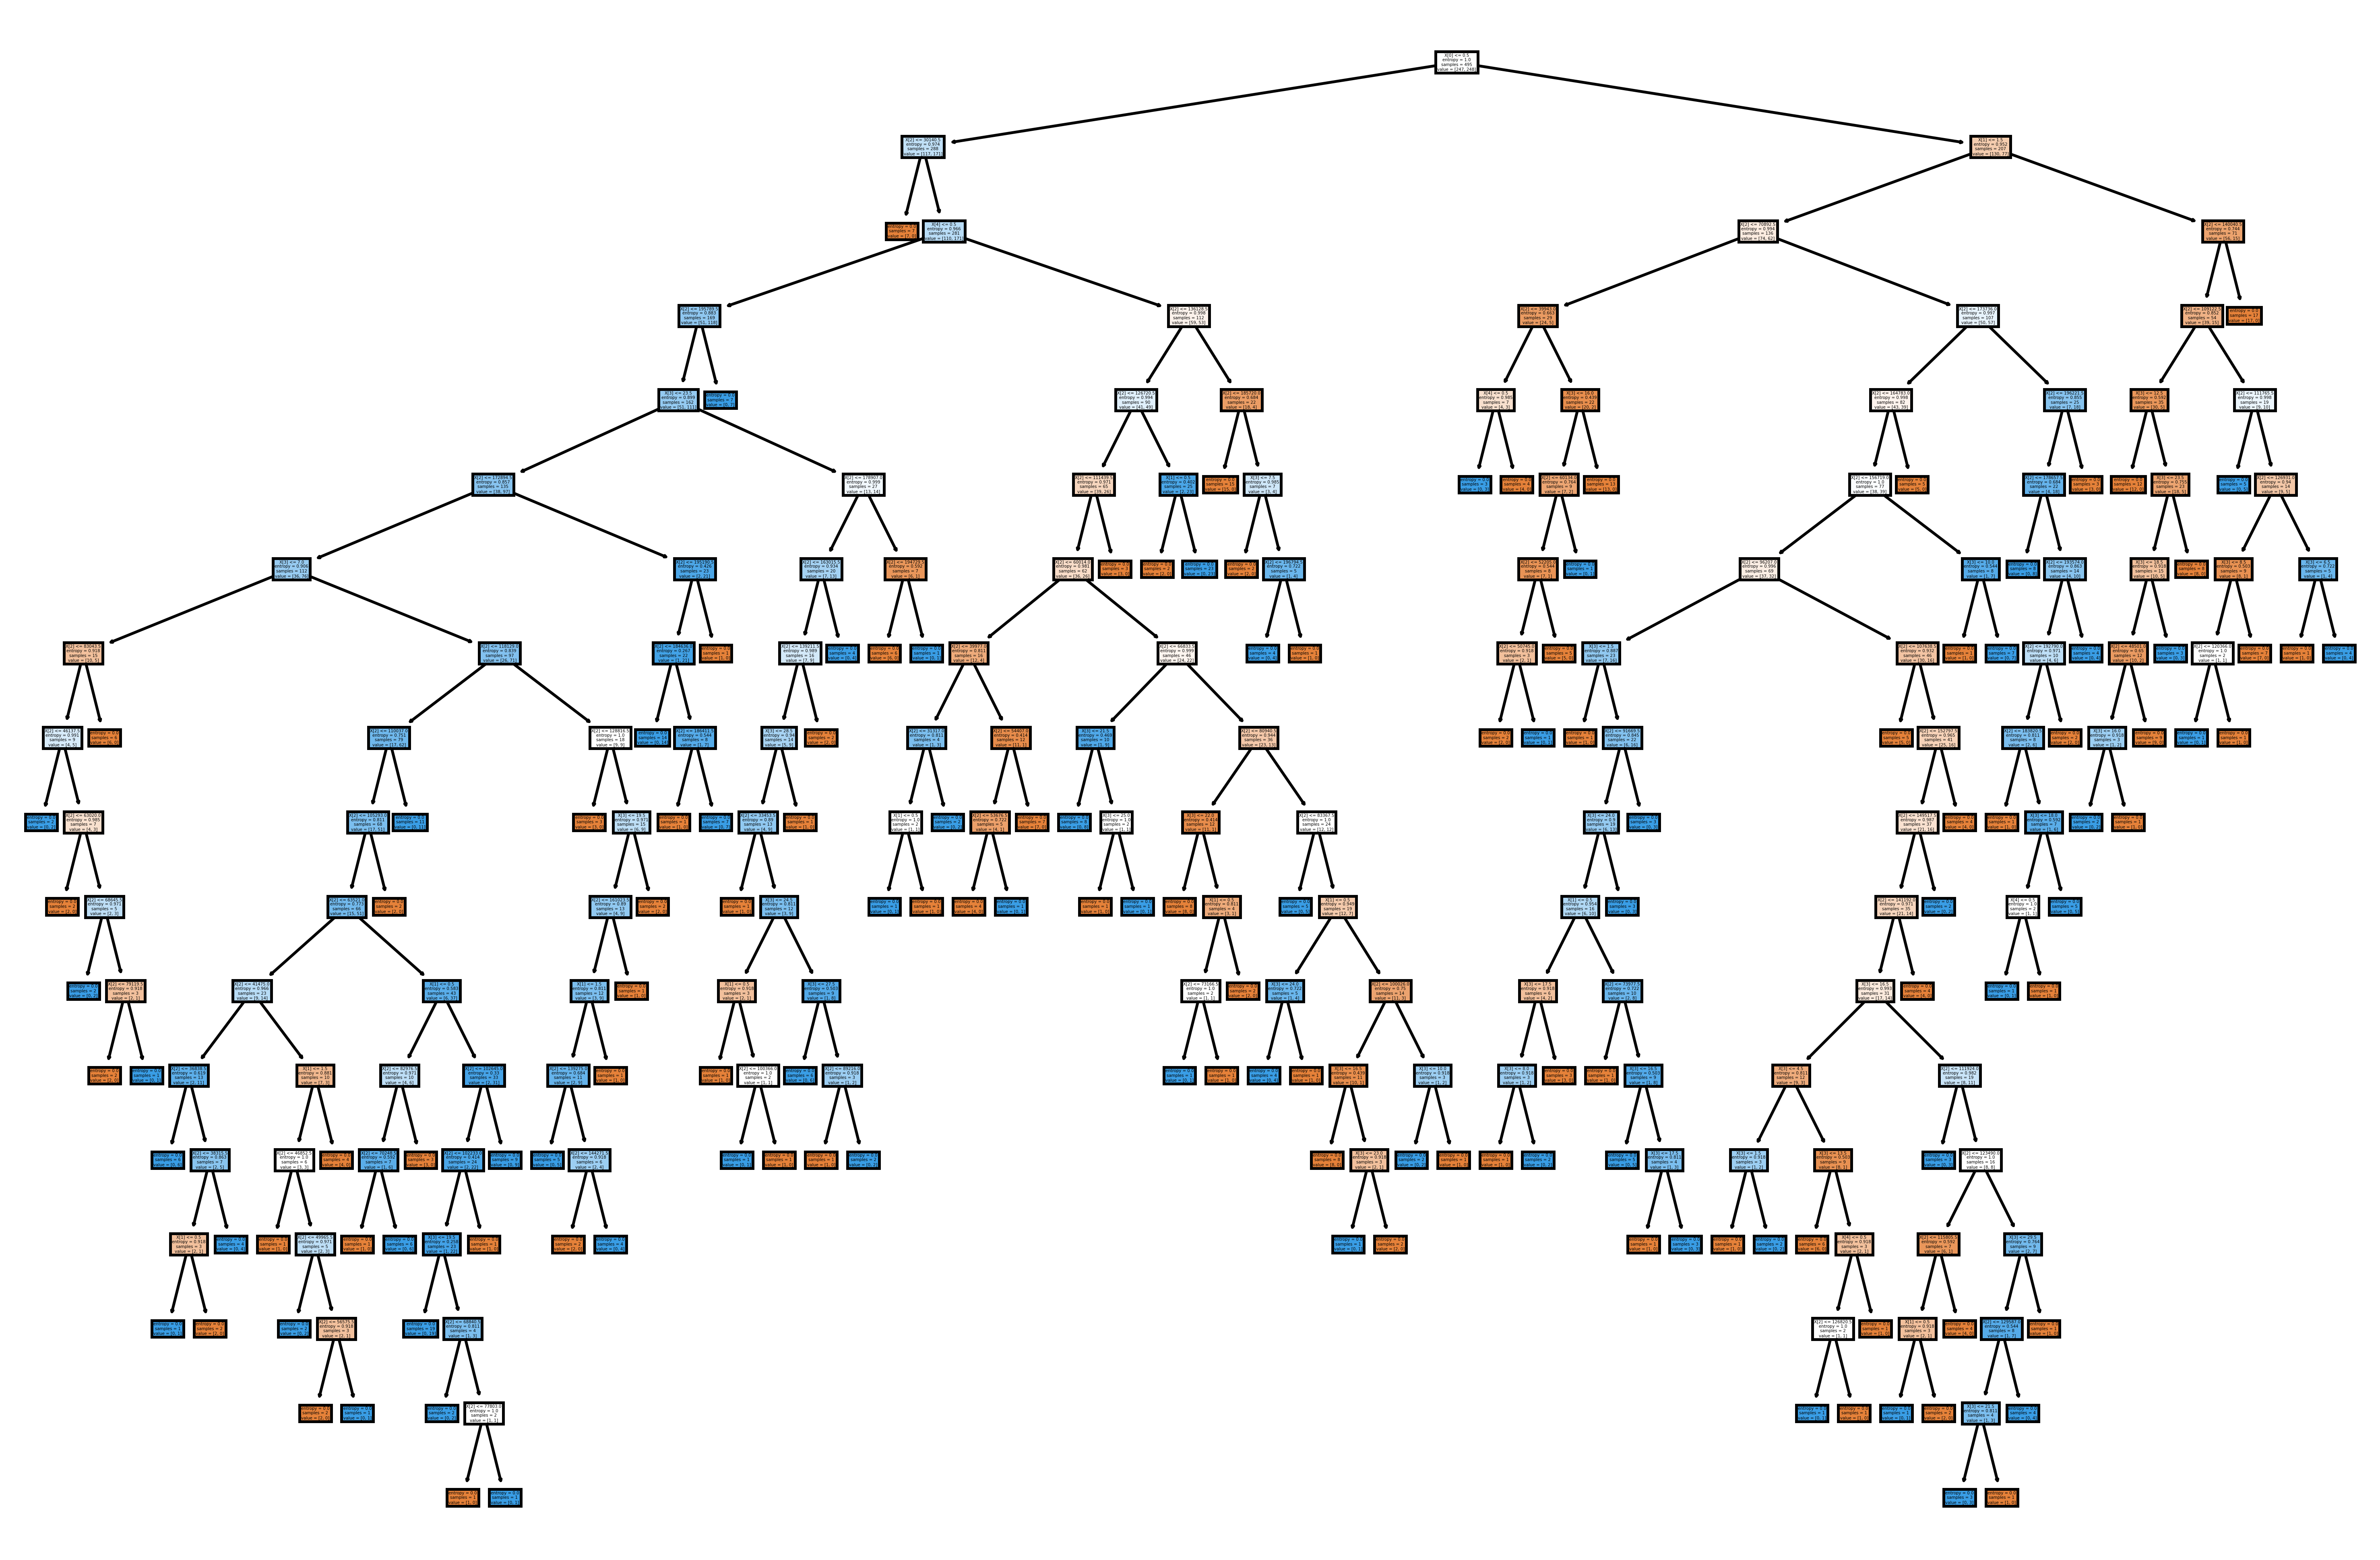

In [50]:
plt.figure(figsize=(15,10),dpi=500)
tree.plot_tree(model_entropy,filled=True)
plt.show()

In [51]:
#Predicting on test data
preds = model_entropy.predict(x_test) # predicting on test data set 
pd.Series(preds).value_counts() # getting the count of each category 

1    114
0     99
dtype: int64

In [52]:
pd.crosstab(y_test,preds) # getting the 2 way table to understand the correct and wrong predictions

col_0              0   1
taxable_category        
0                 72  35
1                 27  79

In [53]:
# Accuracy 
np.mean(preds==y_test)

0.7089201877934272

In [54]:
# Classification Report
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.73      0.67      0.70       107
           1       0.69      0.75      0.72       106

    accuracy                           0.71       213
   macro avg       0.71      0.71      0.71       213
weighted avg       0.71      0.71      0.71       213



In [107]:
path = model_entropy.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [108]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion='entropy',random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.03483671449999548


For the remainder of this example, we remove the last element in `clfs` and `ccp_alphas`, because it is the trivial tree with only one node. Here we show that the number of nodes and tree depth decreases as alpha increases.

[Table of Contents](#0.1)

#### 8.1.1 Accuracy vs alpha for training and testing sets<a class="anchor" id="8.1.1"></a> 
When `ccp_alpha` is set to zero and keeping the other default parameters of :class:`DecisionTreeClassifier`, the tree overfits, leading to a 100% training accuracy and 88% testing accuracy. As alpha increases, more of the tree is pruned, thus creating a decision tree that generalizes better. In this example, setting `ccp_alpha=0.015` maximizes the testing accuracy.

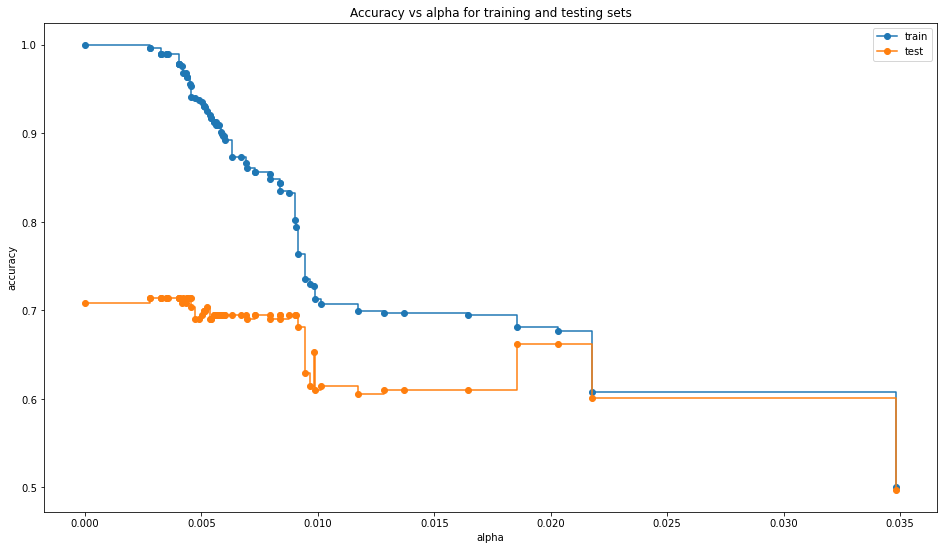

In [109]:
train_scores = [clf.score(x_train, y_train) for clf in clfs]
test_scores = [clf.score(x_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(16,9))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [110]:
ccp_alphas

array([0.        , 0.00278271, 0.00278271, 0.00327789, 0.00327789,
       0.00327789, 0.00347614, 0.00358472, 0.0040404 , 0.0040404 ,
       0.0040404 , 0.0040404 , 0.00418354, 0.0042057 , 0.00432669,
       0.00439244, 0.00439244, 0.00450489, 0.00457508, 0.00457752,
       0.00474448, 0.0048833 , 0.00501596, 0.00510975, 0.00510975,
       0.00510975, 0.00514465, 0.0052586 , 0.00536401, 0.0054222 ,
       0.00543425, 0.00556543, 0.00556543, 0.00563857, 0.00564996,
       0.00568264, 0.00578216, 0.00584666, 0.00586864, 0.00592811,
       0.00599022, 0.0060361 , 0.00633277, 0.00669476, 0.00694089,
       0.00696626, 0.0072922 , 0.0072922 , 0.00794834, 0.00795074,
       0.00836709, 0.00836709, 0.00838426, 0.00878488, 0.00904298,
       0.0090675 , 0.00916011, 0.00946924, 0.00966038, 0.00983548,
       0.00985999, 0.01015159, 0.01171316, 0.0128471 , 0.01371097,
       0.01646919, 0.01856816, 0.02031208, 0.02178524, 0.03483671])

#### Choosing the best value of **`cc_alpha`** where the testing and training accuracy are almost same or near or closer to each other

In [117]:
clf = DecisionTreeClassifier(criterion='entropy',random_state=0, ccp_alpha=0.00983548)
clf.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.00983548, criterion='entropy',
                       random_state=0)

In [118]:
pred_test=clf.predict(x_test)
pred_train=clf.predict(x_train)
from sklearn.metrics import accuracy_score
print('Training Accuracy',accuracy_score(y_train, pred_train),'\n'
'Testing Accuracy',accuracy_score(y_test, pred_test))

Training Accuracy 0.7272727272727273 
Testing Accuracy 0.6525821596244131


              precision    recall  f1-score   support

           0       0.64      0.72      0.68       107
           1       0.68      0.59      0.63       106

    accuracy                           0.66       213
   macro avg       0.66      0.66      0.66       213
weighted avg       0.66      0.66      0.66       213



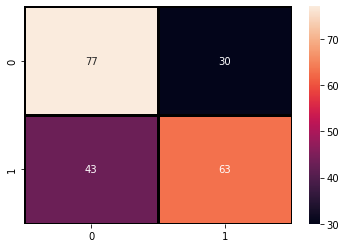

In [119]:
sns.heatmap(confusion_matrix(y_test, pred_test),annot=True,fmt = "d",linecolor="k",linewidths=3)
print(classification_report(y_test,pred_test))

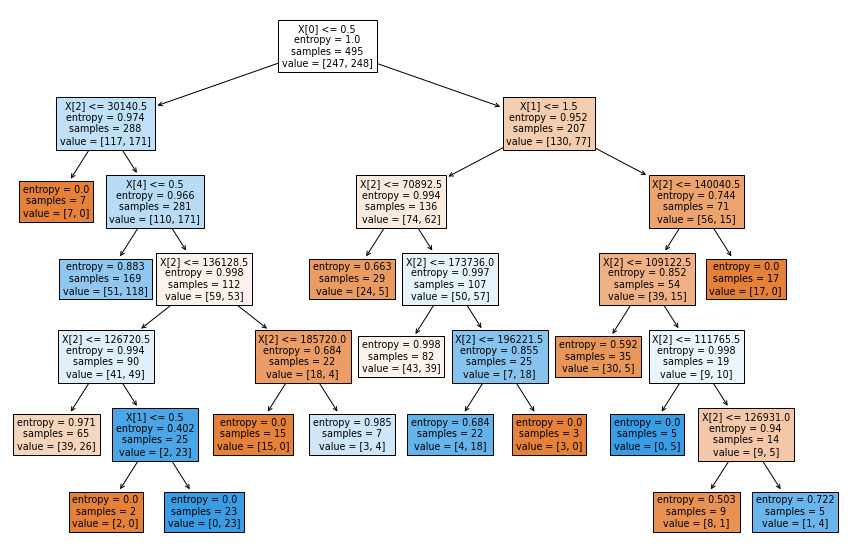

In [120]:
plt.figure(figsize=(15,10))
tree.plot_tree(clf,filled=True)
plt.show()

### 8.2 Building Decision Tree Classifier using Gini Criteria with Alpha values Post Pruning<a class="anchor" id="8.2"></a> 

In [121]:
model_gini = DecisionTreeClassifier(criterion='gini', random_state=0)
model_gini.fit(x_train,y_train)

DecisionTreeClassifier(random_state=0)

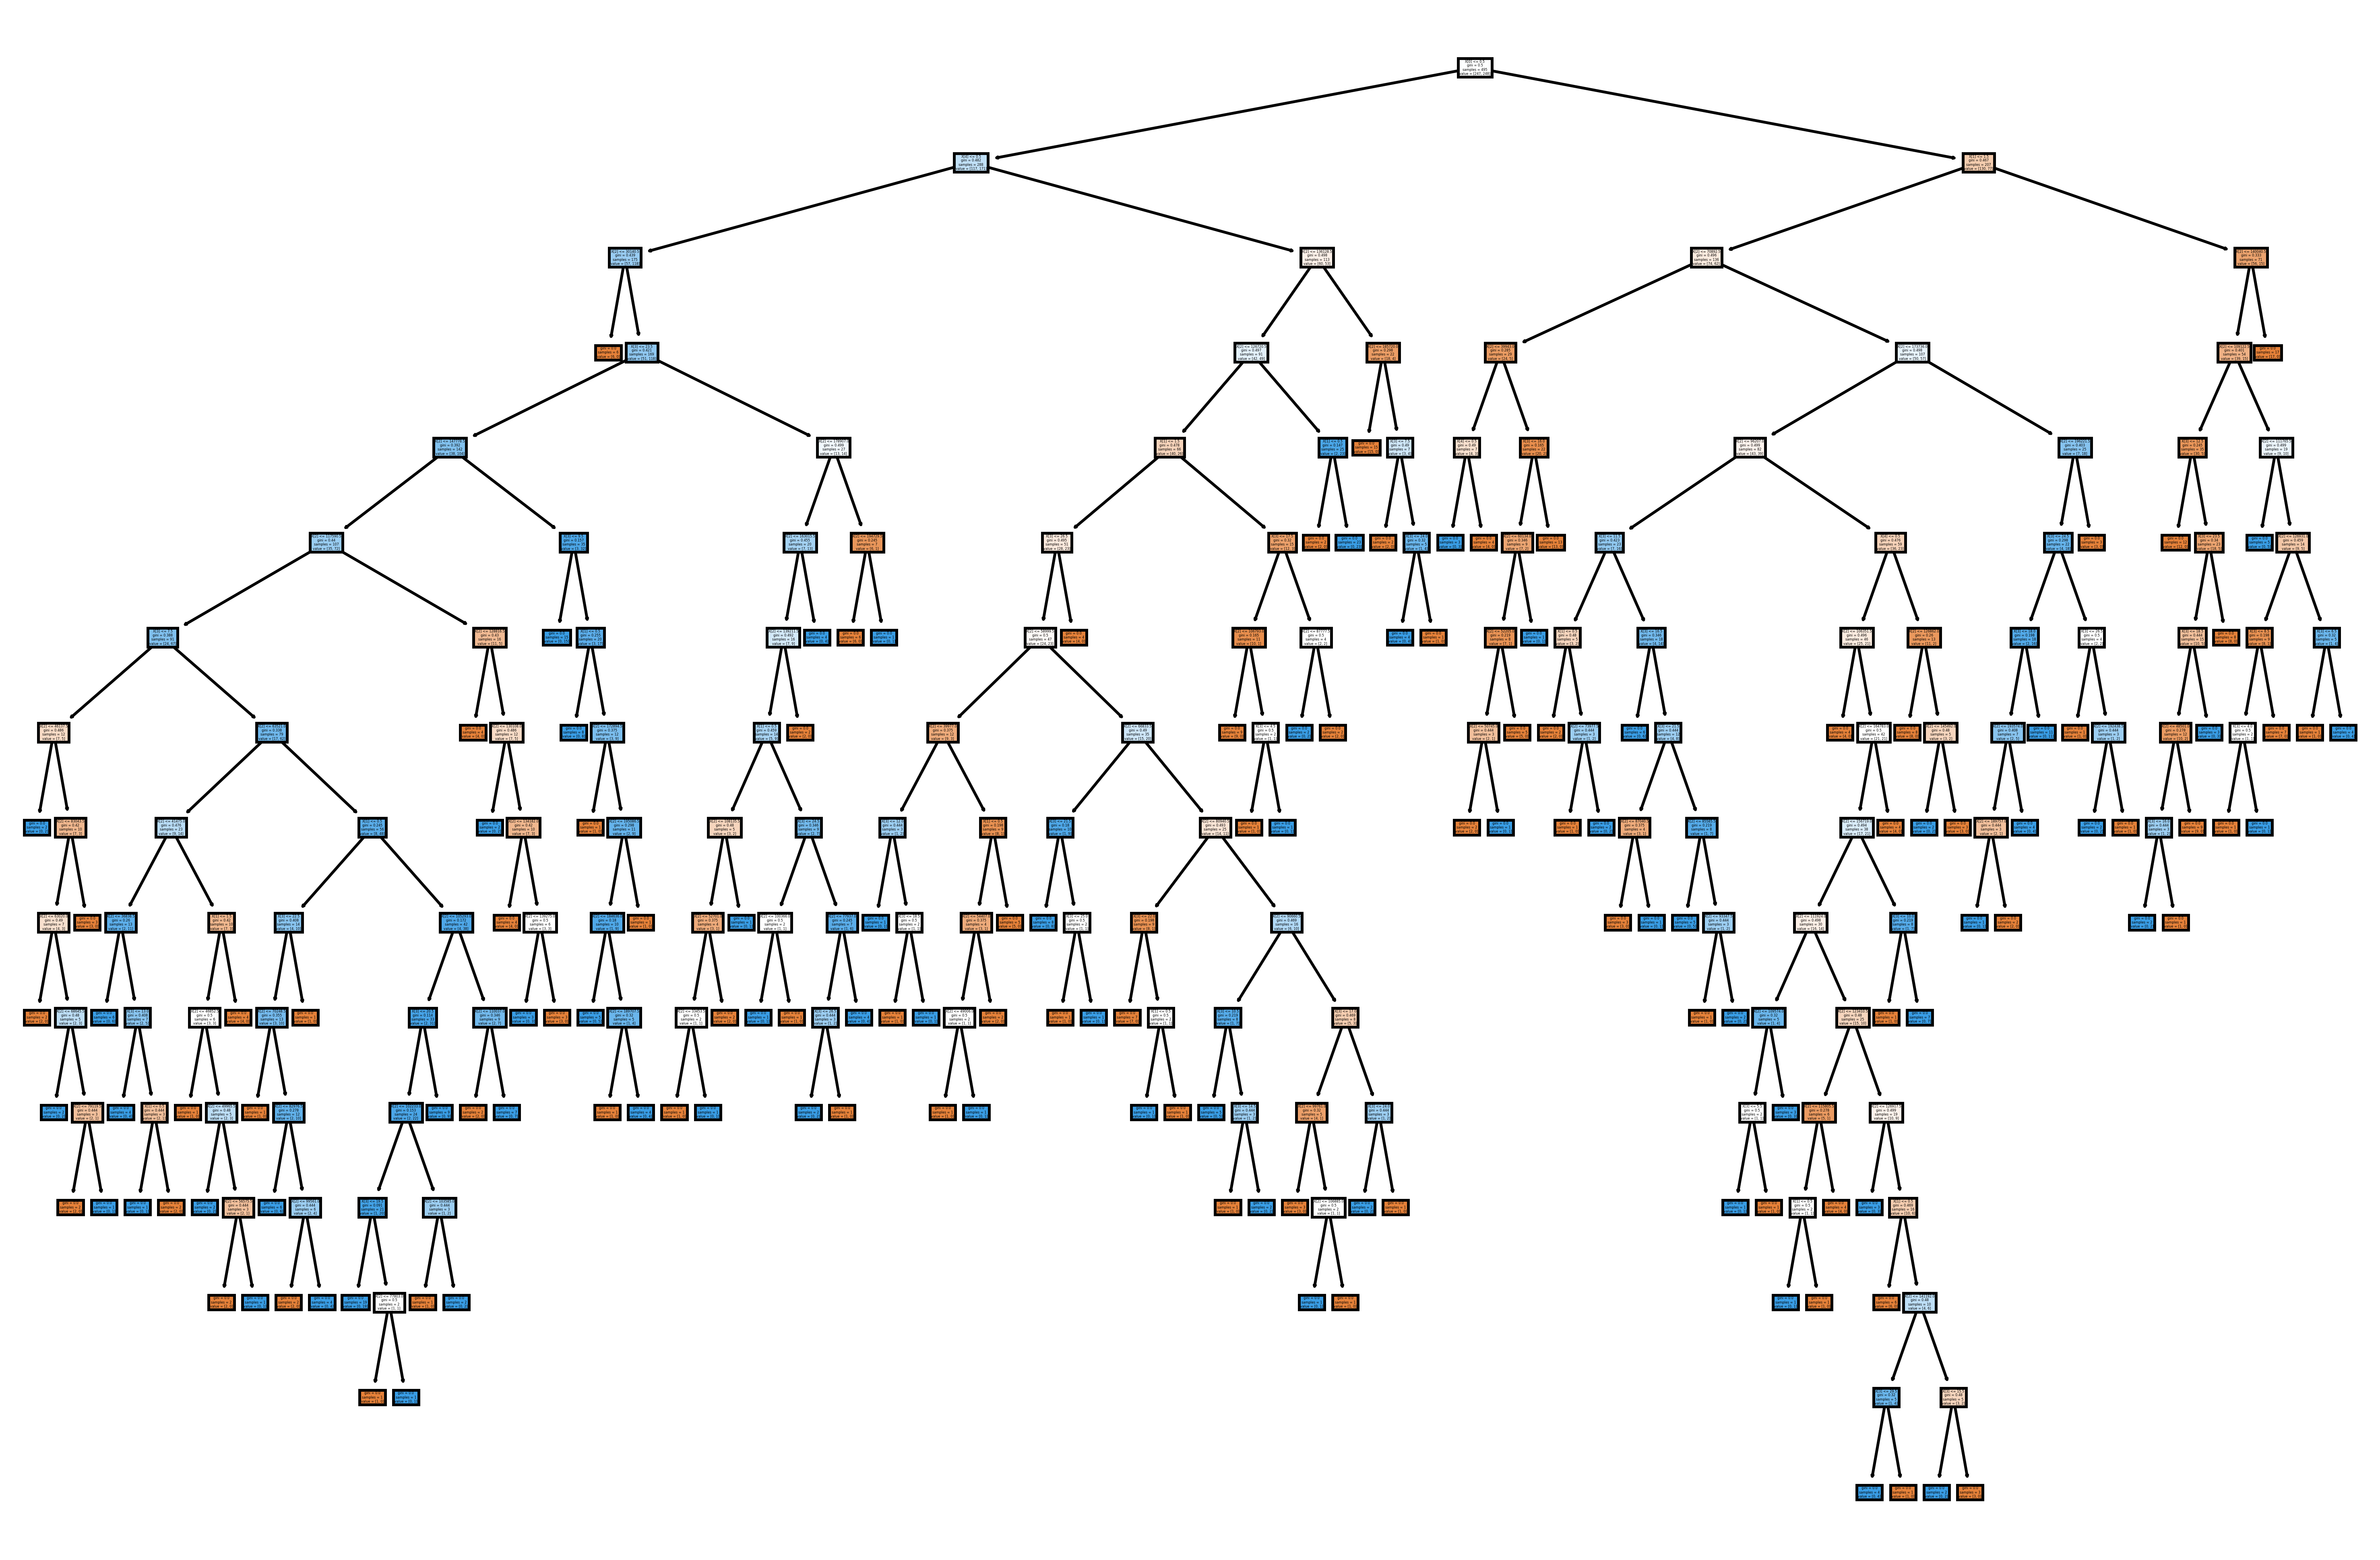

In [122]:
plt.figure(figsize=(15,10),dpi=500)
tree.plot_tree(model_gini,filled=True)
plt.show()

In [123]:
#Predicting on test data
preds = model_gini.predict(x_test) # predicting on test data set 
pd.Series(preds).value_counts() # getting the count of each category 

1    124
0     89
dtype: int64

In [124]:
pd.crosstab(y_test,preds) # getting the 2 way table to understand the correct and wrong predictions

col_0              0   1
taxable_category        
0                 64  43
1                 25  81

In [125]:
# Accuracy 
np.mean(preds==y_test)

0.6807511737089202

In [126]:
# Classification Report
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.72      0.60      0.65       107
           1       0.65      0.76      0.70       106

    accuracy                           0.68       213
   macro avg       0.69      0.68      0.68       213
weighted avg       0.69      0.68      0.68       213



In [127]:
path = model_gini.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [128]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion='gini',random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.023932351623392523


For the remainder of this example, we remove the last element in `clfs` and `ccp_alphas`, because it is the trivial tree with only one node. Here we show that the number of nodes and tree depth decreases as alpha increases.

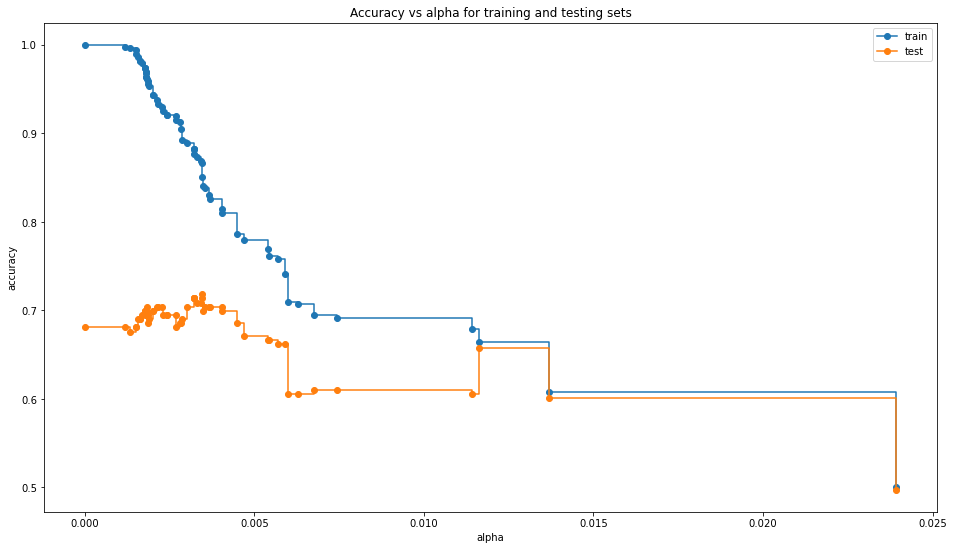

In [129]:
train_scores = [clf.score(x_train, y_train) for clf in clfs]
test_scores = [clf.score(x_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(16,9))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [130]:
ccp_alphas

array([0.        , 0.00119716, 0.0013468 , 0.00151515, 0.00151821,
       0.00157127, 0.00161616, 0.00161616, 0.0016835 , 0.00176768,
       0.00176768, 0.00176768, 0.00179574, 0.00179574, 0.00181818,
       0.00181818, 0.00181818, 0.00183655, 0.00185346, 0.00186147,
       0.00190542, 0.0020202 , 0.0020202 , 0.00212121, 0.00217172,
       0.0022792 , 0.00229568, 0.00242424, 0.00242424, 0.0026936 ,
       0.00269841, 0.00280584, 0.00282279, 0.00287351, 0.00301194,
       0.00323232, 0.00323232, 0.00323232, 0.00323232, 0.00329966,
       0.0034188 , 0.0034632 , 0.00346801, 0.00347222, 0.00353535,
       0.0036556 , 0.00369408, 0.00404033, 0.0040404 , 0.00449995,
       0.00468636, 0.00538827, 0.00543903, 0.00570461, 0.00591554,
       0.00600582, 0.00629673, 0.0067583 , 0.00743434, 0.01141341,
       0.01162234, 0.01368911, 0.02393235])

#### Choosing the best value of **`cc_alpha`** where the testing and training accuracy are almost same or near or closer to each other

In [137]:
clf = DecisionTreeClassifier(criterion='gini',random_state=0, ccp_alpha=0.00600582)
clf.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.00600582, random_state=0)

In [138]:
pred_test=clf.predict(x_test)
pred_train=clf.predict(x_train)
from sklearn.metrics import accuracy_score
print('Training Accuracy',accuracy_score(y_train, pred_train),'\n'
'Testing Accuracy',accuracy_score(y_test, pred_test))

Training Accuracy 0.7414141414141414 
Testing Accuracy 0.6619718309859155


              precision    recall  f1-score   support

           0       0.64      0.72      0.68       107
           1       0.68      0.59      0.63       106

    accuracy                           0.66       213
   macro avg       0.66      0.66      0.66       213
weighted avg       0.66      0.66      0.66       213



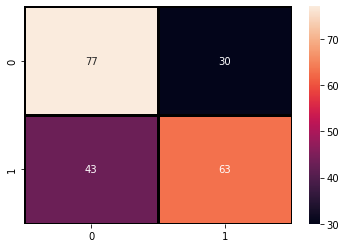

In [139]:
sns.heatmap(confusion_matrix(y_test, pred_test),annot=True,fmt = "d",linecolor="k",linewidths=3)
print(classification_report(y_test,pred_test))

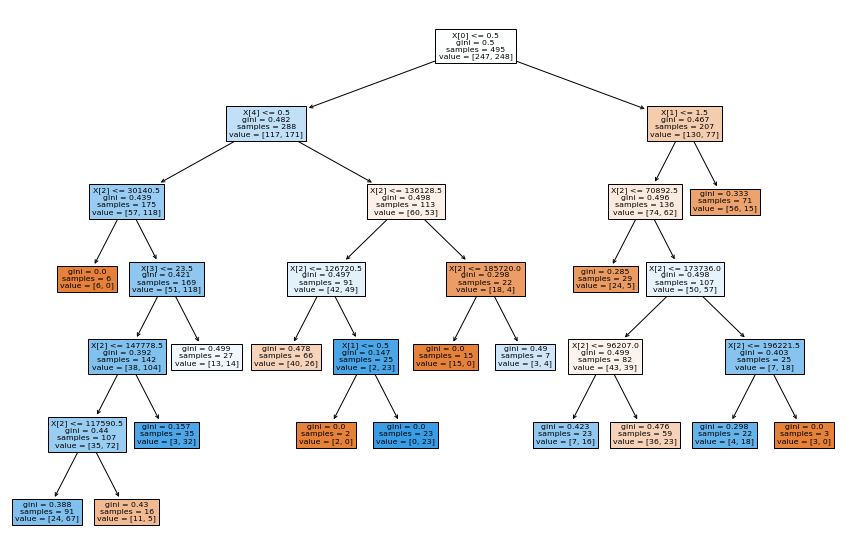

In [140]:
plt.figure(figsize=(15,10))
tree.plot_tree(clf,filled=True)
plt.show()

## 9. Advantages of CART<a class="anchor" id="9"></a> 
+ ### Simple to understand, interpret, visualize.
+ ### Decision trees implicitly perform variable screening or feature selection.
+ ### Can handle both numerical and categorical data. Can also handle multi-output problems.
+ ### Decision trees require relatively little effort from users for data preparation.
+ ### Nonlinear relationships between parameters do not affect tree performance
+ ### It is simple to understand as it follows the same process which a human follow while making any decision in real-life.
+ ### It can be very useful for solving decision-related problems.
+ ### It helps to think about all the possible outcomes for a problem.

## 10. Disadvantages of CART<a class="anchor" id="10"></a> 
+ ### Decision-tree learners can create over-complex trees that do not generalize the data well. This is called overfitting.
+ ### Decision trees can be unstable because small variations in the data might result in a completely different tree being generated. This is called variance, which needs to be lowered by methods like bagging and boosting.
+ ### Greedy algorithms cannot guarantee to return the globally optimal decision tree. This can be mitigated by training multiple trees, where the features and samples are randomly sampled with replacement.
+ ### Decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the data set prior to fitting with the decision tree.
+ ### It may have an overfitting issue, which can be resolved using the Random Forest algorithm.
+ ### For more class labels, the computational complexity of the decision tree may increase.